### Ex4: Distracted Driver Classification  
We've all been there: a light turns green and the car in front of you doesn't budge. Or, a previously unremarkable vehicle suddenly slows and starts swerving from side-to-side.

When you pass the offending driver, what do you expect to see? You certainly aren't surprised when you spot a driver who is texting, seemingly enraptured by social media, or in a lively hand-held conversation on their phone. 

State Farm hopes to improve these alarming statistics, and better insure their customers, by testing whether dashboard cameras can automatically detect drivers engaging in distracted behaviors. Given a dataset of 2D dashboard camera images, State Farm is challenging Kagglers to classify each driver's behavior. Are they driving attentively, wearing their seatbelt, or taking a selfie with their friends in the backseat? 
The 10 classes to predict are:

    c0: safe driving
    c1: texting - right
    c2: talking on the phone - right
    c3: texting - left
    c4: talking on the phone - left
    c5: operating the radio
    c6: drinking
    c7: reaching behind
    c8: hair and makeup
    c9: talking to passenger 
   
https://www.kaggle.com/c/state-farm-distracted-driver-detection 

In [57]:
import mxnet as mx  
from numpy import *
import os, sys
import numpy as np
from scipy.misc import imread, imsave, imresize
from PIL import Image, ImageDraw
# from resizeimage import resizeimage

In [60]:
#Separate the data into train and test datasets 

CLASS=10
MAX_EPOCHS=40
TRAIN=1000
TEST=900
BSIZE=160
HSIZE=120

#input parameter which decides the class & the rest for binary classication
#m=int(sys.argv[1])
m = 0

import pickle

X = np.empty([TRAIN*CLASS, BSIZE*HSIZE], dtype=np.float32)
y = np.empty(TRAIN*CLASS, dtype=int32)
y_pred = np.empty(TRAIN*CLASS, dtype=int32)

Xval = np.empty([TEST*CLASS, 160*120], dtype=np.float32)
yval = np.empty(TEST*CLASS, dtype=int32)

i=0
j=0
jval=0
# This would print all the files and directories
basicPath='/input/distracteddriver'
for i in range(0,10):
    path = basicPath+"/imgs/train/c" + str(i) + "/"
    dirs = os.listdir( path )
    k=0
    for file in dirs:
        if k>(TRAIN+TEST)-1: break
        imagefile = path + file
        img = Image.open(imagefile)
        img = img.resize((BSIZE,HSIZE), Image.ANTIALIAS).convert('L')
        img_arr = np.asarray(img.getdata(),dtype=np.float64)
        img_arr = np.asarray(img_arr,dtype=np.uint8) 
        if k<TRAIN: 
            X[j,] = img_arr.ravel() / 255.  # scale pixel values to [0, 1]
            y[j] = i
            j+=1
        else:
            Xval[jval,] = img_arr.ravel() / 255.  # scale pixel values to [0, 1]
            yval[jval] = i
            jval+=1
        k+=1

X = X.reshape(-1, 1, BSIZE, HSIZE)
Xval = Xval.reshape(-1, 1, 160, 120)

In [61]:
# Check whether the data is OK
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))
import scipy.stats as stats 
stats.itemfreq(y)

print("Xval.shape == {}; Xval.min == {:.3f}; Xval.max == {:.3f}".format(
    Xval.shape, Xval.min(), Xval.max()))
print("yval.shape == {}; yval.min == {:.3f}; yval.max == {:.3f}".format(
    yval.shape, yval.min(), y.max()))
import scipy.stats as stats 
print(stats.itemfreq(y))
print(stats.itemfreq(yval))


X.shape == (10000, 1, 160, 120); X.min == 0.000; X.max == 1.000
y.shape == (10000,); y.min == 0.000; y.max == 9.000
Xval.shape == (9000, 1, 160, 120); Xval.min == 0.000; Xval.max == 1.000
yval.shape == (9000,); yval.min == 0.000; yval.max == 9.000
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]
[[  0 900]
 [  1 900]
 [  2 900]
 [  3 900]
 [  4 900]
 [  5 900]
 [  6 900]
 [  7 900]
 [  8 900]
 [  9 900]]


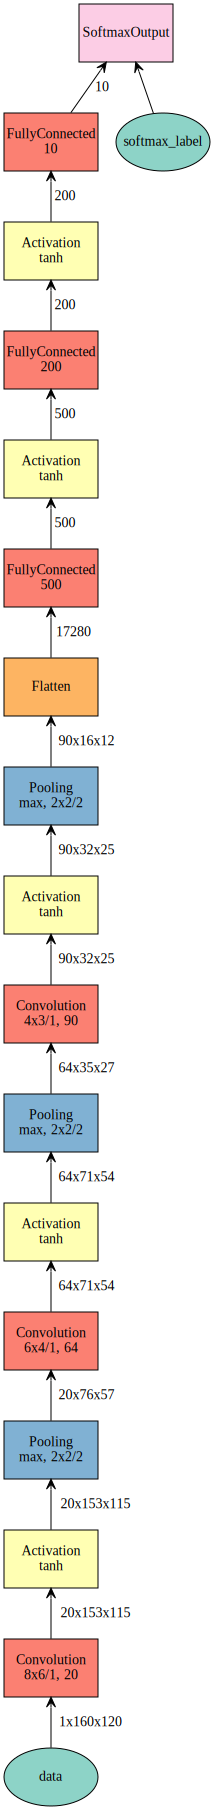

In [62]:
# Define the CNN 
def distDrCNN():
    data    = mx.symbol.Variable('data')
    # first convolution
    conv1   = mx.symbol.Convolution(data=data, kernel=(8,6), num_filter=20)
    act1    = mx.symbol.Activation(data=conv1, act_type='tanh')
    pool1   = mx.symbol.Pooling(data=act1, pool_type='max',
                                kernel=(2,2), stride=(2,2))

    # second convolution
    conv2   = mx.symbol.Convolution(data=pool1, kernel=(6,4), num_filter=64)
    act2    = mx.symbol.Activation(data=conv2, act_type='tanh')
    pool2   = mx.symbol.Pooling(data=act2, pool_type='max',
                                kernel=(2,2), stride=(2,2))

    # third convolution
    conv3   = mx.symbol.Convolution(data=pool2, kernel=(4,3), num_filter=90)
    act3    = mx.symbol.Activation(data=conv3, act_type='tanh')
    pool3   = mx.symbol.Pooling(data=act3, pool_type='max',
                                kernel=(2,2), stride=(2,2))
    # first fully connected
    flatten = mx.symbol.Flatten(data=pool3)
    hidden4 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    act4    = mx.symbol.Activation(data=hidden4,act_type='tanh')

    # second fully connected
    hidden5 = mx.symbol.FullyConnected(data=act4, num_hidden=200)
    act5    = mx.symbol.Activation(data=hidden5, act_type='tanh')

    # output layer
    output  = mx.symbol.FullyConnected(data=act5, num_hidden=10)
    
    # soft loss function
    lenet = mx.sym.SoftmaxOutput(data=output,name='softmax')
    return lenet

dCNNinst=distDrCNN()
batch_size = 100
shape = {"data" : (batch_size, 1, BSIZE, HSIZE)}
mx.viz.plot_network(symbol=dCNNinst, shape=shape) 

In [ ]:
# Load and fit the model 
import logging
logging.getLogger().setLevel(logging.DEBUG)

device = mx.cpu() 
model = mx.model.FeedForward(
    symbol = dCNNinst,       # network structure
    ctx=device,
    num_epoch =50,     # number of data passes for training 
    learning_rate=0.01,
    momentum = 0.1,
    wd= 0.001,
    initializer=mx.init.Uniform(0.1),
   #initializer        = mx.init.Xavier(factor_type="in", magnitude=2.34)
)
batch_size=500
model.fit(
    X=X,y=y,       # training data
    eval_data=(Xval,yval), # validation data
    eval_metric='acc',
    batch_end_callback = mx.callback.Speedometer(batch_size, 100)
)

/home/lpola/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  del sys.path[0]
/home/lpola/mxnet/python/mxnet/model.py:516: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=326.318
INFO:root:Epoch[0] Validation-accuracy=0.142253
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=358.290
INFO:root:Epoch[1] Validation-accuracy=0.143229
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=329.421
INFO:root:Epoch[2] Validation-accuracy=0.231445
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=344.030
INFO:root:Epoch[3] Validation-accuracy=0.189128
INFO:root:Epoch[4] Resetting Data It

In [ ]:
# Save and load the model  
prefix = 'mymodel'
iteration = 50
model.save(prefix)
model_loaded = mx.model.FeedForward.load(prefix, iteration) 

val_iter = mx.io.NDArrayIter(Xval)


In [63]:
# Predict the result using the pre-trained model 
prefix = "fullymodel" # Trained using AWS GPU 
model_loaded = mx.model.FeedForward.load(prefix, 50) 
yval_p=model_loaded.predict(Xval) 

[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


In [64]:
#Get the performance metrics for the validation data 

import math 
type(yval_p) 
ind=np.argsort(yval_p)
tp,fp=0,0
tn,fn=0,0
mlogloss=0 
for i in range(len(yval)):
   # print(i,yval_p[i],yval_p[i].argmax())
    mlogloss
    if yval[i]==0:
        if yval_p[i].argmax()==0: tp+=1 
        else: fn+=1     
    else:     
        if yval_p[i].argmax()!=0: tn+=1
        else:  fp+=1 
    mlogloss+=-math.log(yval_p[i][yval[i]])   
mlogloss=mlogloss/len(yval)                
pd0=tp/float(tp+fn)
pd1=tn/float(tn+fp)
accuracy=float(tp+tn)/float(tp+fp+tn+fn)
precision0=float(tp)/float(tp+fp)
precision1=float(tn)/float(tn+fn)
print('pd0=',pd0,'; pd1=',pd1,'; accuracy=',accuracy,
      '; precision0',precision0,'; precision1:',precision1,'; mlogloss:',mlogloss)

('pd=', 0.9788888888888889, '; accuracy=', 0.9962222222222222, '; precision0', 0.9832589285714286, '; precision1:', 0.9976554787759131, '; mlogloss:', 0.054714051404995113)


In [65]:
prefix = "fullymodel" # Trained using AWS GPU 
fullymodel_loaded = mx.model.FeedForward.load(prefix, 50) 

[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


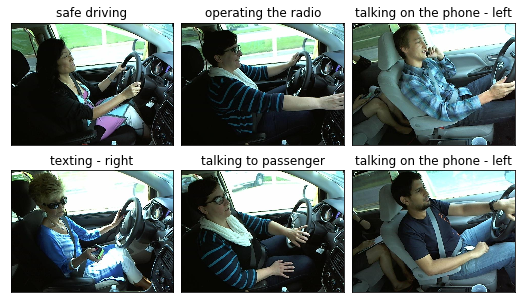

In [66]:
# Test the results using the pretrained model 
import random 
import numpy as np 
import cv2 
from os import listdir

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as pyplot 

CLASS=10
BSIZE=160
HSIZE=120
bpath='/input/distracteddriver/imgs/train'
pnum=6 
dictM={0:'safe driving',1:'texting - right',2:'talking on the phone - right',
  3:'texting - left',4:'talking on the phone - left',
  5:'operating the radio',6:'drinking',7:'reaching behind',
  8:'hair and makeup',9:'talking to passenger'}
pallfiles=[]
fig = pyplot.figure(figsize=(7,4))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
cls=range(0,10)
random.shuffle(cls)

for i in range(0,pnum):
    subd=cls[i]
    bpathimg=bpath+'/c'+str(subd)
    files=listdir(bpathimg)
    imgpath=bpathimg+'/'+files[random.randint(0,(len(files)-1))]
    img = Image.open(imgpath)
    img = img.resize((BSIZE,HSIZE), Image.ANTIALIAS).convert('L')
    img_arr = np.asarray(img.getdata(),dtype=np.float64)
    img_arr = np.asarray(img_arr,dtype=np.uint8) 
    XX = np.empty([1, BSIZE*HSIZE], dtype=np.float32)
    XX[0,]= img_arr.ravel() / 255.  # scale pixel values to [0, 1]
    XX = XX.reshape(-1, 1, BSIZE, HSIZE)
    prob=fullymodel_loaded.predict(XX)[0]
    label = dictM[prob.argmax()]
    img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.set_title(label) 
    ax.imshow(img) 
pyplot.show() 